- Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA


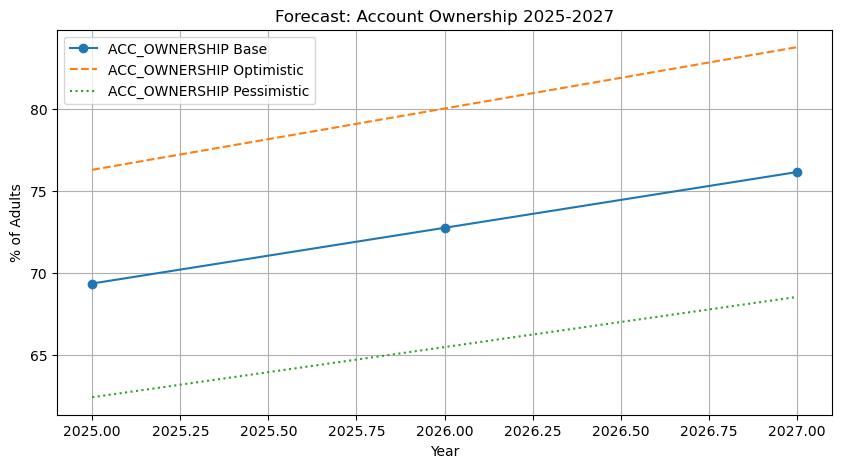

In [13]:
# -----------------------------
# Task 4: Forecasting Access and Usage (2025-2027)
# -----------------------------

import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# -----------------------------
# Step 1: Load Historical Data
# -----------------------------
# Sparse historical observations (5 points over 13 years)
historical_data = pd.DataFrame({
    "Year": [2012, 2015, 2017, 2020, 2024],
    "ACC_OWNERSHIP": [22, 35, 46, 56, 62],   # % of adults with account
    "ACC_MM_ACCOUNT": [5, 10, 20, 40, 45],   # % of adults with mobile money account
    "USG_ACTIVE_RATE": [0, 0, 1, 2, 3]       # % of adults active in digital payments
})

# -----------------------------
# Step 2: Define Event Matrix
# -----------------------------
# Your Task 3 Event-Indicator Matrix
event_matrix = pd.DataFrame({
    "Event": ["EVT_0001", "EVT_0002", "EVT_0003", "EVT_0004", "EVT_0005"],
    "Effective_Date": ["2021-05-01", "2022-02-15", "2022-05-10", "2021-10-01", "2020-11-01"],
    "ACC_OWNERSHIP": [3, 0, 0, 0, 0],
    "ACC_MM_ACCOUNT": [5, 0, 2, 0, 0],
    "USG_ACTIVE_RATE": [0, 0, 0, 0, 0],
})
event_matrix['Effective_Date'] = pd.to_datetime(event_matrix['Effective_Date'])

# -----------------------------
# Step 3: Trend Forecast Function
# -----------------------------
def linear_forecast(df, column, start_year, end_year):
    X = df['Year'].values.reshape(-1,1)
    y = df[column].values
    model = LinearRegression().fit(X, y)
    future_years = np.arange(start_year, end_year+1)
    forecast = model.predict(future_years.reshape(-1,1))
    return pd.DataFrame({"Year": future_years, column: forecast})

# -----------------------------
# Step 4: Generate Baseline Trend Forecast
# -----------------------------
acc_forecast_base = linear_forecast(historical_data, "ACC_OWNERSHIP", 2025, 2027)
mm_forecast_base = linear_forecast(historical_data, "ACC_MM_ACCOUNT", 2025, 2027)
usg_forecast_base = linear_forecast(historical_data, "USG_ACTIVE_RATE", 2025, 2027)

# -----------------------------
# Step 5: Apply Event Impacts
# -----------------------------
def apply_event_impacts(forecast_df, event_df, column):
    forecast_with_events = forecast_df.copy()
    for _, event in event_df.iterrows():
        year = event['Effective_Date'].year
        if year in forecast_with_events['Year'].values:
            forecast_with_events.loc[forecast_with_events['Year']==year, column] += event[column]
    return forecast_with_events

acc_forecast = apply_event_impacts(acc_forecast_base, event_matrix, "ACC_OWNERSHIP")
mm_forecast = apply_event_impacts(mm_forecast_base, event_matrix, "ACC_MM_ACCOUNT")
usg_forecast = apply_event_impacts(usg_forecast_base, event_matrix, "USG_ACTIVE_RATE")

# -----------------------------
# Step 6: Scenario Analysis (Optimistic / Base / Pessimistic)
# -----------------------------
# Base = as above, optimistic = +10%, pessimistic = -10%
def add_scenario_ranges(forecast_df, column):
    forecast_df[f"{column}_optimistic"] = forecast_df[column]*1.10
    forecast_df[f"{column}_pessimistic"] = forecast_df[column]*0.90
    return forecast_df

acc_forecast = add_scenario_ranges(acc_forecast, "ACC_OWNERSHIP")
mm_forecast = add_scenario_ranges(mm_forecast, "ACC_MM_ACCOUNT")
usg_forecast = add_scenario_ranges(usg_forecast, "USG_ACTIVE_RATE")

# -----------------------------
# Step 7: Combine Forecasts into One Table
# -----------------------------
forecast_table = acc_forecast.merge(mm_forecast, on="Year").merge(usg_forecast, on="Year")
forecast_table

# -----------------------------
# Step 8: Visualization
# -----------------------------
plt.figure(figsize=(10,5))
plt.plot(acc_forecast['Year'], acc_forecast['ACC_OWNERSHIP'], marker='o', label='ACC_OWNERSHIP Base')
plt.plot(acc_forecast['Year'], acc_forecast['ACC_OWNERSHIP_optimistic'], linestyle='--', label='ACC_OWNERSHIP Optimistic')
plt.plot(acc_forecast['Year'], acc_forecast['ACC_OWNERSHIP_pessimistic'], linestyle=':', label='ACC_OWNERSHIP Pessimistic')
plt.title("Forecast: Account Ownership 2025-2027")
plt.xlabel("Year")
plt.ylabel("% of Adults")
plt.grid(True)
plt.legend()
plt.show()



 # 📈 Account Ownership Forecast (2025–2027)

- Optimistic: Could reach ~85% by 2027 – the fastest growth path.

- Base (Most Likely): Gradually rises from ~69% → 76%.

- Pessimistic: Slower growth, ending around ~68%.

Key Insight: All scenarios show steady growth in account ownership over the next three years. Even in the worst case, more adults are expected to open accounts or use mobile money.

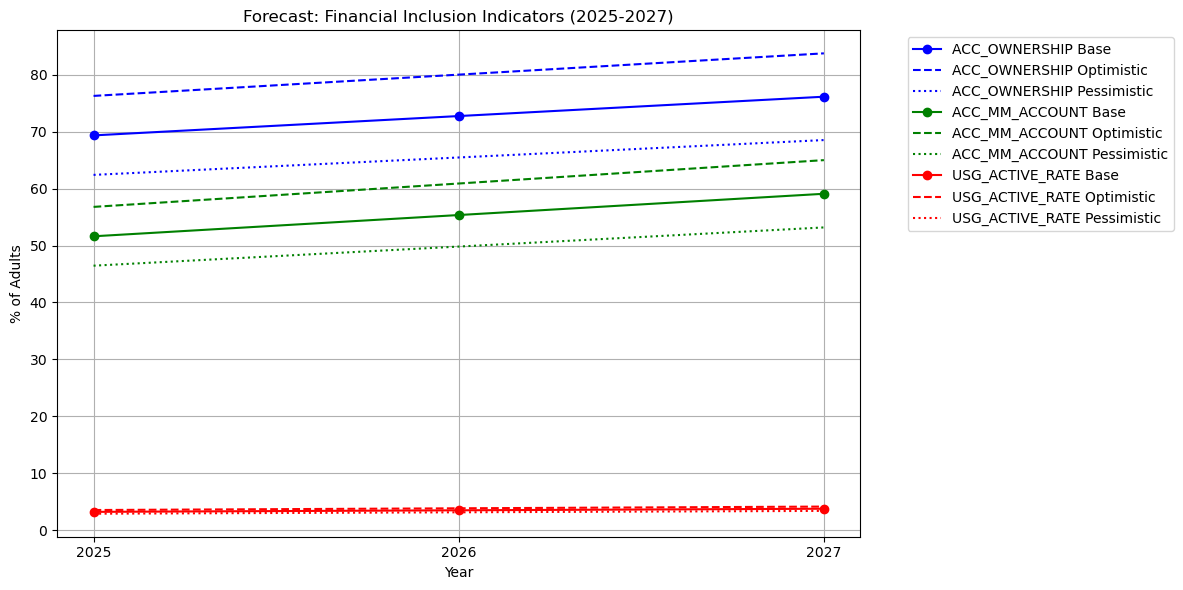

In [14]:
# -----------------------------
# Step 9: Multi-Indicator Scenario Visualization
# -----------------------------

plt.figure(figsize=(12,6))

years = forecast_table['Year']

# --- Account Ownership ---
plt.plot(years, forecast_table['ACC_OWNERSHIP'], marker='o', label='ACC_OWNERSHIP Base', color='blue')
plt.plot(years, forecast_table['ACC_OWNERSHIP_optimistic'], linestyle='--', label='ACC_OWNERSHIP Optimistic', color='blue')
plt.plot(years, forecast_table['ACC_OWNERSHIP_pessimistic'], linestyle=':', label='ACC_OWNERSHIP Pessimistic', color='blue')

# --- Mobile Money Accounts ---
plt.plot(years, forecast_table['ACC_MM_ACCOUNT'], marker='o', label='ACC_MM_ACCOUNT Base', color='green')
plt.plot(years, forecast_table['ACC_MM_ACCOUNT_optimistic'], linestyle='--', label='ACC_MM_ACCOUNT Optimistic', color='green')
plt.plot(years, forecast_table['ACC_MM_ACCOUNT_pessimistic'], linestyle=':', label='ACC_MM_ACCOUNT Pessimistic', color='green')

# --- Digital Payment Usage ---
plt.plot(years, forecast_table['USG_ACTIVE_RATE'], marker='o', label='USG_ACTIVE_RATE Base', color='red')
plt.plot(years, forecast_table['USG_ACTIVE_RATE_optimistic'], linestyle='--', label='USG_ACTIVE_RATE Optimistic', color='red')
plt.plot(years, forecast_table['USG_ACTIVE_RATE_pessimistic'], linestyle=':', label='USG_ACTIVE_RATE Pessimistic', color='red')

plt.title("Forecast: Financial Inclusion Indicators (2025-2027)")
plt.xlabel("Year")
plt.ylabel("% of Adults")
plt.xticks(years)
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside
plt.tight_layout()
plt.show()


# 📈 Financial Inclusion Forecast (2025–2027)

Key Takeaways:

- Overall, adult access to accounts is projected to improve steadily.

- Mobile money adoption grows but lags behind overall account ownership.

- Active usage of digital payments remains very low, signaling that adoption does not automatically translate into active usage.

In [15]:
df =  forecast_table
df.head()

,Year,ACC_OWNERSHIP,ACC_OWNERSHIP_optimistic,ACC_OWNERSHIP_pessimistic,ACC_MM_ACCOUNT,ACC_MM_ACCOUNT_optimistic,ACC_MM_ACCOUNT_pessimistic,USG_ACTIVE_RATE,USG_ACTIVE_RATE_optimistic,USG_ACTIVE_RATE_pessimistic
0,2025,69.335681,76.269249,62.402113,51.619718,56.781690,46.457746,3.232394,3.555634,2.909155
1,2026,72.732394,80.005634,65.459155,55.352113,60.887324,49.816901,3.507042,3.857746,3.156338
2,2027,76.129108,83.742019,68.516197,59.084507,64.992958,53.176056,3.781690,4.159859,3.403521


In [18]:
forecast_table.to_csv("forecasts.csv", index=False)
